# STACKING AND BLENDING #

**Stacking:**  Involves training new models based on the predictions of previous models and original features in the dataset.  Weight models based on their accuracy. Works better when combining DIFFERENT models to increase the possible signals it can capture - thus reducing bias of the model.

**Bagging:**  Simply take average of predictions.  COmbines similar models to reduce variance (thus, expected loss).

**Stacking Example**

* Level 0: 2 separate Models (example KNN and SVM).
* STACKING
* Level 1: Logistic Regression
* OUTPUT  

Used the logistic regression to combine the output of the 2 previous models.

**Training a Stacked Model**
* Need to use test/train splits correctly to avoid overfitting.
* Need to train our level 0 models in a way that the predictions are based on data the model has not seen.  

**2 ways to overcome**
* Stacking:  Slightly more thorough and complicated.
* Bleanding

**OPTION 1: STACKING**
* Split data into folds like with cross validation.
* Instead of calculating GoF statistic on each fold - we are saving the predictions from each fold.  Results in predictions for entire dataset with data that wasn't seen yet.
* These predictions (from all Level 0 models) is used to train our Level 1 model.

**OPTION 2: BLENDING**
* A simplified version of stacking.
* Create single holdout sample and create predictions only on that sample. 
* Level 1 model only trained on this.
* Advantages: simpler implementation - less chance of trianing model on same data you are predicting.
* Drawback: all models trained using much less data.

* Interpretation of blended and stacked models requires use of *partial dependency plots*
* The stacked/blended models are always more difficult to interpret than the component models.
* Best suited for situations where interpretation not as important.

**SET UP MORTALITY DATA FOR STACKING**

In [3]:
data.mortality <- read.csv("soa_mortality_data.csv")

# Set the target (note we need to use labels that are valid "names" in R because of a function we use later on)
data.mortality$target[data.mortality$actual_cnt == 0] = "X0"
data.mortality$target[data.mortality$actual_cnt >= 1] = "X1"


# Set the variables we want to use for training
vars <- c(
          "issstate",
          "distchan",
          "smoker",
          "sex",
          "issage"
)
data.mortality <- data.mortality[,c("target",vars)]


# Split data into training and testing - here we use a convenient function from caret
library(caret)
set.seed(21)
partitions <- createDataPartition(data.mortality$target, times = 1, p = 0.7)
data.training <- data.mortality[partitions$Resample1,]
data.testing <- data.mortality[-partitions$Resample1,]

# Create folds for the training data - here we use the convenient function createFolds from caret
set.seed(45)
data.folds <- createFolds(data.training$target, k=3) # This creates a list. Each element has the indices corresponding to that fold


Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


**Train Random Forest on 3 Subsets**

In [4]:
# Set up the parameters for the caret training process
rfGrid <- expand.grid(mtry = c(1,3,5,7)) # The minimum node size for the decision tree (complexity)
ctrl <- trainControl(method = "cv", number = 5,
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     sampling = "down") 

# Structure to store the results in
rf.results <- list()

# For each of the folds we need to train the model on the other folds and generate predictions for that fold
i <- 1 # index to keep track of elements
for (thisFold in data.folds) {

  # Set up the data
  training.fold <- data.training[-thisFold,] # notice the "-" which means everything "except" this fold.
  testing.fold <- data.training[thisFold,]
  
  # Train the model
  rf.model.fold <- train(target ~.,
                         data = training.fold,
                         method = "rf", # This is so we use the randomForest algorithm
                         trControl = ctrl,
                         tuneGrid = rfGrid,
                         ntree = 50
                         )
  
  # Create the predictions from the model (we are using probabilistic outputs here)
  preds.fold <- predict(rf.model.fold, newdata = testing.fold, type = "prob")$X1 
  
  # Store the results
  results.fold <- list(model = rf.model.fold, predictions = preds.fold) # This creates an object containing the model and the predictions for this fold
  rf.results[[i]] <- results.fold # This adds the object to the list of results for the random forest (there should be one per fold)
  i <- i + 1 # increment the index for the next iteration
}


Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

In [5]:
# Note here we will use glmnet with caret (so techincally penalized logistic regression) so that we automatically perform feature selection within the logistic regression model

# Set up the parameters for the caret training process
lrGrid <- expand.grid(alpha = seq(0,1,by=0.1),
                      lambda = "all")
ctrl <- trainControl(method = "cv", number = 5,
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     sampling = "down") 

# Structure to store the results in
lr.results <- list()

# For each of the folds we need to train the model on the other folds and generate predictions for that fold
i <- 1 # index to keep track of elements
for (thisFold in data.folds) {

  # Set up the data
  training.fold <- data.training[-thisFold,] # notice the "-" which means everything "except" this fold.
  testing.fold <- data.training[thisFold,]
  
  # Train the model
  lr.model.fold <- train(target ~.,
                         data = training.fold,
                         method = "glmnet", # This is so we use the glmnet algorithm 
                         trControl = ctrl,
                         tuneGrid = lrGrid,
                         family = "binomial"
                         )
  
  # Create the predictions from the model (we are using probabilistic outputs here)
  preds.fold <- predict(lr.model.fold, newdata = testing.fold, type = "prob")$X1 
  
  # Store the results
  results.fold <- list(model = lr.model.fold, predictions = preds.fold) # This creates an object containing the model and the predictions for this fold
  lr.results[[i]] <- results.fold # This adds the object to the list of results for the random forest (there should be one per fold)
  i <- i + 1 # increment the index for the next iteration
}


Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

# ADD PREDICTIONS #

In [6]:
# Modify the training data to include the predictions of the level 0 models
for (i in 1:length(data.folds)) {
  data.training$RF_Preds[data.folds[[i]]] <- rf.results[[i]]$predictions
  data.training$LR_Preds[data.folds[[i]]] <- lr.results[[i]]$predictions
}

ERROR: Error in `$<-.data.frame`(`*tmp*`, "RF_Preds", value = c(0.08, NA, NA, : replacement has 349991 rows, data has 350001


**TRAIN LEVEL 1 GBM**

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

eXtreme Gradient Boosting 

350001 samples
     5 predictor
     2 classes: 'X0', 'X1' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 175000, 175001 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  eta   max_depth  colsample_bytree  ROC        Sens       Spec     
  0.01  1          0.6               0.7070136  0.6425106  0.6719775
  0.01  1          0.9               0.7069276  0.6492947  0.6554202
  0.01  3          0.6               0.7193362  0.5951909  0.7517963
  0.01  3          0.9               0.7246788  0.5969866  0.7566386
  0.01  7          0.6               0.7208714  0.6169197  0.7271165
  0.01  7          0.9               0.7187058  0.6088784  0.7360200
  0.10  1          0.6               0.7117479  0.5939977  0.7377382
  0.10  1          0.9               0.7111474  0.6142742  0.7136832
  0.10  3          0.6               0.7128584  0.6197573  0.7116526
  0.10  3          0.9               0

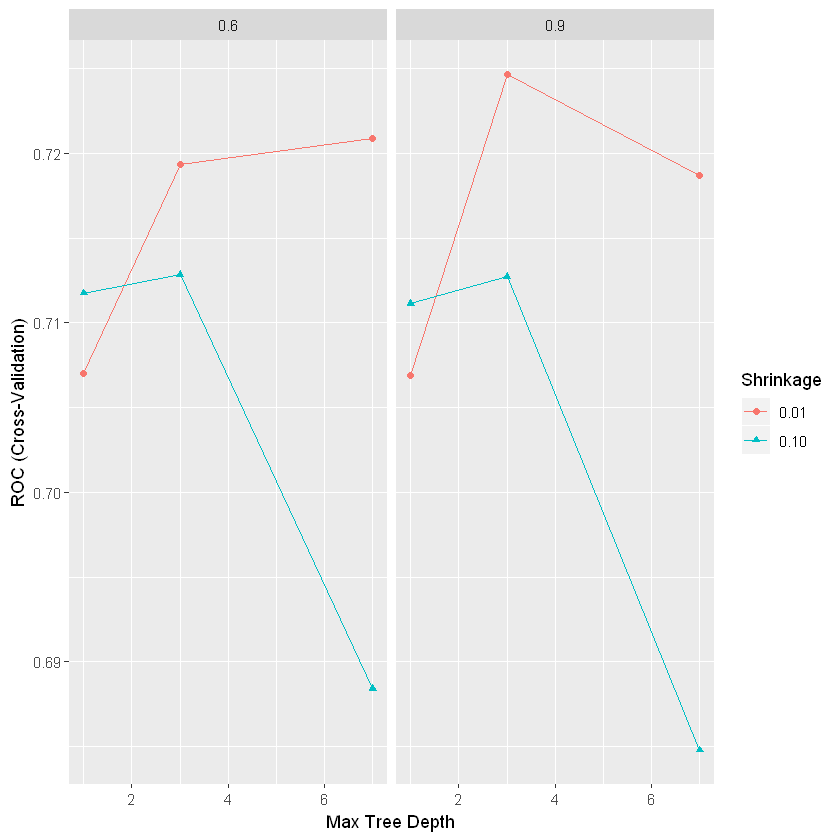

In [7]:
# Set up tuning parameters
xgbGrid <- expand.grid(max_depth = c(1,3,7),
                      nrounds = 700,
                      eta = c(0.01, 0.1),
                      colsample_bytree = c(0.6, 0.9),
                      gamma = 0,
                      min_child_weight = 1,
                      subsample = 0.6
                      ) 

# Set up control parameters
ctrl <- trainControl(method = "cv", number = 2, # In the interest of computation time, we will do 2-fold cross validation
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     sampling = "down" 
                     ) 

# Train the level 1 model
model.xgbstack.tuned <- train(target ~.,
                        data = data.training,
                        method = "xgbTree", # This is so we use the xgboost algorithm
                        trControl = ctrl,
                        tuneGrid = xgbGrid
                        )

# Check the output
model.xgbstack.tuned
ggplot(model.xgbstack.tuned)

# Note the results here will be slightly worse than the trained GBM from the previous section because we are using a smaller initial variable set for training (you can change this if you wish)


# HYPERPARAMETER TUNING WITH GRID SEARCH #

**Hyperparameters vs Model Parameters**

* Moel parameters are the part of the model we are trying to learn.
* Hyperparameters are parameters that have an effect on the model performance (and are used as part of the model optimization).
* Either don't appear directly in the model form - or are considered fixed within model form.
* Often part of the algorithm's *objective function* as opposed to the model itself.

**Hyperparameter Tuning Approaches**
* Manaually tune.  Simplest approach.
* Obviously not an optimal approach - prime candidate for automation.
* **Grid Search:** One of the more obvious and common methods (although not necessarily most effective).


# GRID SEARCH #

* Hyperparameter tuning process that involves specifying for each hyperparameter a series of values we would like to test.
* Exhaustively build and test the model for *each combination* of hyperparameter values to ID the best set.
* Quickly suffers from curse of dimensionality.
* Caret package has some good tools for grid search.

**Other Hyperparameter Tuning Methods**
*Random Search:* Similar to grid search - but only tests randomly chosen subset (not grid search ~exhaustive subset).
* Often more efficient than grid search.
*Gradient Based Optimization:* Involves computing the gradient of the objective function wrt model parameters and adjusting iteratively such that we move in the negative direction of gradient towards minimum of objecive function (or positive if maximizing).
*Bayesian Optimization:* Bayesian approach to gradient descent.  Objective function is the likelihood and we assume prior distribution over hyperparameters.  With each iteration calc new posterior over hyperparameters.  Gradually get closer to optimal eagles.



# Support Vector Machines #

* ML algorithm originally developed as a binary classification tool.
* Has been expanded to multiclass classification and regression.
* NOTE:  SVM is a *decision model* which decides if a data point belongs in one class or another - not the probability that it belongs to each class.
* Advanced topic - and derivations are very technical.  

* To start:  Explore idea behind method.
* Apply SVM to survival analysis:   predict whether an individual survives to t - given survival to (t-1).
* This is a common application for SVM - literature is available.


**SVM Concept**
* Split data into 2 groups:  Surived and Did Not Survive.
* Want to find a line (in 2D example) called *hyperplane* for more than 2D such that it splits survive or not.
* There are many lines that accomplish this split.  Need to determine the *best* line.
* The best line not only splits the groups - but it *maximizes the margin* between the line and closest data points from each class.
* This is referred to as "Finding the Maximum Margin Hyperplane".
* A lot more info - but skipped in interest of time.

# BAYESIAN LEARNING #

* Refers to a collection of algorithms that approach the problem of learning a predictive model using the *Bayesian* statistical framework as opposed to the *frequentist* framework.

* Recall:  under frequentist approach - estimated our parameters based on likelihood they generated observed data (i.e. MLE).
* Whereas: under Bayesian - we consider a prior distribution over possible values of parameters and then determine posterior distribution after having observed the data.
* This means Bayesian algorithms start with some *prior* belief about the parameters of the predictive model - and as data comes in - parameters are updated to reflect what the new *evidence* implies.

* Fundamentally - Bayesian approach involves estimating the *posterior distribution of the model parameters* and then  obtaining best values of those parameters by looking at the mode (or other stat) of the posterior distribution.
* Recall Bayes Formula:  
$P(\theta|X)=\frac{P(X|\theta)P(\theta)}{P(X)}$

WHERE:  
* X represents observed data
* $\theta$ represents model parameters (likely a vector)
* $P(\theta)$ represents the **PRIOR** distribution over model parameters.  Indicates - prior to observation - which parameter values are more likely than others.
* $P(X|\theta)$ represents likelihood of seeing data X given particular parameter values $/theta$.  Also reflects the choice of the model (which is how the parameters determine the probabilities of observing the possible outcomes).
* P(X) is a normalizing factor and represents distribution of the data - it averages the likelihood over all possible parameter values.
* $P(\theta|X)$ is the **POSTERIOR** distribution of the model parameters - given the data we saw.

* In most cases - only the target variable's distribution depends on the parameter values and predictor variables.
* Distribution of the predictor variables does not depend on parameter values.
* Bayesian uses Maximum a Posteriori vs Frequentist Maximum Likelihood.

**KEY DIFFERENCE**
* **Frequentist:** parameters are fixed (but unknown) and observations are random.
* **Bayesian:** observations are fixed and parameters are random.  Think of the probability distribution of a parameter as the likelihood the parameter is correct.  This likelihood is based on everything we know about the underlying process *prior* to observing the data.

# BAYESIAN BONUS #
* We can observe the posterior distribution with updated parameters.  Thus - we can see exactly how our knowledge of the unknown parameter has changed due to the collection of data.
* Learning w each observation?

# ADDITIONAL DIFFERENCE #
* MLE: No constraints - all parameters are equally available - thus - overfitting is likely as the method tries to match data best as possible.
* Bayesian strikes a compromise between data and prior distribution.  Prediction will be between prior and observed.

# WHY ISN'T BAYESIAN ANALYSIS MORE POPULAR #
* 2 Major reasons: 
* First: many people are uncomfortable w the notion of a prior distribution.  It is a subjective expression of the current knowledge about unknown parameters.  Thus 2 analysts could get 2 different results by employing different a priori distributions.
* Response: Subjectivity is a part of frequentist approach as well.  Can also use *uninformative* or *vague* priors.  These priors provide as little weight as possible - allowing data to dominate.  

* Second: Computationally challenging integrals.  These are not as much of a concern w modern computing power.

# ADDITIVE MODELS #
* Parametric Models: make assumptions about underlying model form that "generates" the observed data.  In particular - the probability distribution implied by the model depends on a limited number of quantities - called parameters.
* Non-Parametric: makes no assumption about model form. EX: KNN.
* Parametric tend to have higher bias.  They are less flexible and have less ability to match the true process.
* Parametric tend to have lower variance - as they are less likely to overfit.
* For example:  100 observations fit to a Gamma distribution will give a good estimate of parameters - but will fail to the extent that Gamma is not the true distribution.  A non-parametric model gives 1/N probability to each data point (empirical distribution).  Extremely flexible - but clearly tied to observations and may be less predictive.


**Additive Models**
* Attempt to bridge the 2 extremes above.  Are of the form:

$y = \beta_0 + r_1(x_1) + ... + r_M(x_M) + \epsilon$
* Each function is unspecified but smooth.  The simplification is that the functions are each univariate and additive.
* This form gives us flexibility over parametric models in that we don't assume an underlying model form restricted by the parameters.
* However - we lose the ability to automatically handle interactions as in fully nonparametric - because we require that our functions are univariate.
* Additive models tend to have lower bias than parametric and lower variance than fully non-parametric models.

**NON-PARAMETRIC SMOOTHING FUNCTIONS**
General form of the additive model should feel familiar.  We have not yet discussed the non-parametric smoothing functions we might use to fit these models.  The most common non-parametric smoothing functions fall into 2 categories:  
* Scatterplot Smoothers: uses a function of nearby training data points to create estimation of the target variable of a new data point.
* Splines: takes the form of a piecewise polynomial - pieces defined by a collection of knots.

**SPLINES**  
* Fit multiple polynomial regressions - one for each segment of the data - defined by knots.
* At these knots - polynomial on L will join smoothly w polynomial on R which produces required smooth function.
* In practice - cubic splines typically used.

# GENERALIZED ADDITIVE MODELS (GAMs) #
* Linear Model + Link ---> GLM ~ Additive Model + Link ---> GAM
* Concurvity: Analagous concept to multicollinearity - one parameter ~ smooth function of other parameter(s).
* Difficult to detect - utilize cross validation analysis for stability of model

# NEURAL NETWORKS #
* Biological NNs are an interconnected web of neurons that communicate w each other via elaborate patterns of electrical signals.  Neurons receive an input signal and - if sufficiently activated - fire an output signal.  Impact on downstream neurons depends on strength of connections between these neurons.

**Artifical Neural Network**
* Consist of basic neurons (aka units or nodes) arranged in layers - receive input - send output (when sufficiently activated). 
* Output is sent to connected nodes w amount of influence dependent on their connection weight.
* Typical NNs have: 
    * INPUT LAYER
    * INTERMEDIATE (HIDDEN) LAYER
    * OUTPUT LAYER
* Each feature in the input dataset is usually mapped to a single neuron in the input layer.
* Input neurons are connected to each member of the next layer with a weight.
* Through training - connections between neurons in each layer strengthened/weakened based on predictive power.
* Back-propagation is the process of adjusting weights using a graded descent algorithm.


**Definitions**
* There are many types of NNs - some details may vary by your selection.
* *Units:* Individual neurons/nodes in network.  Arranged into *layers* with one or more units per layer.  In a traditional feed-forward NN - each unit in one layer will be connected to each nuit in the next layer.
* *Links:* Connections between units.
* *Weights:* Associated with each link to determine strength and sign of the connection.
* *Activation Function:* The function that relates the input to a unit of the activation state of that unit.  One of the following:
    * Perceptron: hard threshold
    * Sigmoid: logistic function
    * Some nonlinear function
* Typically a sigmoid function is used as it produces outputs close to 0 or 1.
* You could use a linear function if desired - but results in ~GLM and power of NN is their nonlinearity.

**Definitions Continued**
* Layers: Collection of units.
* Input Layer: Units and links that receive the data as their input.  Usually each unit in the input layer corresponds to a feature in the input data.
* Hidden Layers: Collection of units between input and output layer.  Each hidden layer usually responsible for extracting a certain type of information (usually increasingly abstract).  For example w images - one for edges, one for shapes, etc.
* Output Layer: Final layer of the NN whose outputs are transformed into the final classification for regression value.

**Training a Neural Network**
* Standard process is called *back-propagation* which is performed in conjunction with an optimization algorithm (ex. gradient descent optimization).  General process as follows: 
1. Training data is used to make predictions (one at a time) and comapre predictions w actual target.  You need initial weights - often done randomly.
2. After a predictiion - partial gradient of the error function calculated wrt each weight from *final layer* of the network.  These are then adjusted (according to the *learning rate*) in the negative direction of the gradient.
3. Errors are then *propagated* backwards through the network where at each layer the partial derivatives are calculated such that the weights can be adjusted in the negative direction of the gradient.  Useful predictors usually get a heavier weight.
4. Repeated until all data is used.
* Key strength of NN is that they are constantly learning from new data.

**Training a Neural Network Continued**
* Scale the features in the input data - they directly affect the weights.
* Better to have too many hidden units than too few.
* NN easily overparameterized - so overfitting is an issue.  Regularization and Cross Validation will help.
* Can get stuck at local min instead of global.  Use bagging to help alleviate.

**Tensorflow**
* Open source software library for machine intelligence.  
* RStudio has page dedicated to **R Interface to TensorFlow**